# **Predecir Ventas**

Instalaciones:
* pip install pandas
* pip install xlrd (para leer archivos de extension xls)
* pip install matplotlib
* pip install openpyxl
* pip install seaborn
* pip install scikit-learn
* pip install xgboost
* pip install sklearn-genetic-opt

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical
from sklearn.metrics import mean_absolute_error

dfData = pd.read_excel('../Data Original/VENTAS KERA TEIN.xls')
#df = df[['Fecha','Fecha entrega','Cant. pedida', 'Cant. pendiente', 'Cant. comprom.', 'Cant. remision', 'Cant. factura']]
dfData = dfData[['Fecha','Cant. pedida']]
dfData = dfData.sort_values(by='Fecha')


# Función para obtener el lunes anterior a una fecha dada
def obtener_lunes_anterior(fecha):
    # Calcular el lunes anterior
    lunes_anterior = fecha - pd.DateOffset(days=fecha.weekday())
    return lunes_anterior

dfData['LunesAnterior'] = dfData['Fecha'].apply(obtener_lunes_anterior)

# Establecer la columna 'Fecha' como el índice del DataFrame
dfData['FechaMes'] = dfData['Fecha'].dt.to_period('M').dt.to_timestamp()

dfData = dfData[['Fecha','LunesAnterior','FechaMes','Cant. pedida']]

df_dia = dfData.groupby('Fecha').agg({'Cant. pedida':'sum'}).reset_index()
df_semana = dfData.groupby('LunesAnterior').agg({'Cant. pedida':'sum'}).reset_index()
df_mes = dfData.groupby('FechaMes').agg({'Cant. pedida':'sum'}).reset_index()

df_dolar = pd.read_csv('../Data Original/Datos históricos USD_COP.csv')

df_dolar['Fecha'] = pd.to_datetime(df_dolar['Fecha'], format='%d.%m.%Y')
df_dolar['Apertura']  = df_dolar['Apertura'].str.replace('.', '').str.replace(',', '.').astype(float)
df_dolar = df_dolar[['Fecha','Apertura']].copy()

df_dolar.rename(columns={'Apertura':'Dolar'}, inplace=True)
df_dolar=df_dolar.sort_values(by='Fecha', ascending=True).reset_index(drop=True)

df_dolar['FechaMes'] =  df_dolar['Fecha'].dt.to_period('M').dt.to_timestamp()


df_desempleo = pd.read_excel('../Data Original/Desempleo.xlsx')
df_desempleo = df_desempleo[df_desempleo['Fecha']>='2016-01-01']
df_desempleo.columns = ['FechaMes','Desempleo']
df_desempleo.reset_index(inplace=True,drop=True)



# DOLAR POR MES
df_dolar_mes = df_dolar.groupby('FechaMes').agg({'Dolar':['max','min','mean']}).reset_index()
df_dolar_mes.columns = ['FechaMes','dolar_max','dolar_min','dolar_mean']


# DESEMPLEO POR MES:   viene con fechas que cambian.   se colocan todos como el primer día del mes.
df_desempleo['FechaMes'] = (df_desempleo['FechaMes'] + pd.offsets.MonthBegin(1)).dt.to_period('M').dt.to_timestamp()

dfTotal = pd.merge(df_mes, df_dolar_mes, on='FechaMes', how='inner')
dfTotal = pd.merge(dfTotal, df_desempleo, on='FechaMes', how='inner')

dfTotal['Mes'] = dfTotal['FechaMes'].dt.month
dfTotal['Trimestre'] = dfTotal['FechaMes'].dt.quarter

import numpy as np
def convierte_df_historico(df, historia):
    
    arreglo = []

    for i in range(historia, len(df)):   
        fila = [df['Cant. pedida'].iloc[i].tolist()]
        dolar_max = df['dolar_max'].iloc[i-historia:i].tolist()
        fila.extend(dolar_max)
        dolar_min = df['dolar_min'].iloc[i-historia:i].tolist()
        fila.extend(dolar_min)
        dolar_mean = df['dolar_mean'].iloc[i-historia:i].tolist()
        fila.extend(dolar_mean)
        Desempleo = df['Desempleo'].iloc[i-historia:i].tolist()
        fila.extend(Desempleo)
        Mes = df['Mes'].iloc[i-historia:i].tolist()
        fila.extend(Mes)
        Trimestre = df['Trimestre'].iloc[i-historia:i].tolist()
        fila.extend(Trimestre)

        arreglo.append(fila)
    return(np.array(arreglo))

# **8. Modelos**



CORTE:  Define en donde hacemos el corte de data para TRAINING y versus TESTING
HISTORIA:  señala cuanta historia utilizar en cada fila.

Para cada HISTORIA 
* obtenemos  el mejor conjunto de parámetros (incluyendo HISTORIA)
* re-entrenamos este modelo con toda la data de tranining disponible (hasta -6) -> predecimos (-5) y repetimos hasta llegar a -1.
* calculamos el error


   


In [83]:
dfTotal

,FechaMes,Cant. pedida,dolar_max,dolar_min,dolar_mean,Desempleo,Mes,Trimestre
0,2017-09-01,120.0,2946.25,2892.15,2918.210476,9.52,9,3
1,2017-11-01,40.0,3065.00,2974.00,3014.794091,8.74,11,4
2,2017-12-01,80.0,3031.85,2958.50,2991.371905,8.76,12,4
3,2018-01-01,80.0,2984.50,2790.30,2872.967391,8.91,1,1
4,2018-02-01,120.0,2936.00,2796.80,2857.659000,12.14,2,1
...,...,...,...,...,...,...,...,...
72,2024-05-01,1080.0,3917.00,3819.95,3867.410435,10.65,5,2
73,2024-07-01,2479.1,4148.63,3922.17,4038.896957,10.27,7,3
74,2024-08-01,1680.0,4155.62,4005.22,4063.025909,9.92,8,3
75,2024-09-01,1620.0,4279.60,4147.26,4190.302381,9.66,9,3


In [ ]:


lista_resultados = []

parametros_rf = {
    'n_estimators': [int(x) for x in range(10, 400, 10)],
    'max_depth': [int(x) for x in range(1, 20)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

CORTE = 6   # Número de meses a usar como TEST (no se incluyen en TRAIN)
            # Luego de obtenido el mejor modelo para todas las historias, sabemos tanto la mejor historia como los mejores parámetros del mejor modelo

lista_resultados = []

ANOS_UTILIZAR_EN_DATA = [2018, 2019, 2020, 2021]

for AAU in ANOS_UTILIZAR_EN_DATA:

    # Solo vamos a tomar en cuenta filas desde el año AAU
    dataAUtilizar = dfTotal[dfTotal['FechaMes'].dt.year >= AAU]
    # eliminamos la columna FechaMes que no debe estar en el arreglo numpy
    dataAUtilizar = dataAUtilizar.drop('FechaMes', axis=1)

    for HISTORIA in range(1, 12):

        print('historia=', HISTORIA)

        arreglo = convierte_df_historico(dataAUtilizar, HISTORIA)

        # obtenemos la data
        y = arreglo[:, 0]  # todas las filas y tomamos solo la columna 0
        X = arreglo[:, 1:] # todas las filas y tomamos todas las columnas desde la 1 en adelante

        # escalamos
        y_scaler = MinMaxScaler()
        X_scaler = MinMaxScaler()
        y_scaled = y_scaler.fit_transform(y.reshape(-1,1))
        X_scaled = X_scaler.fit_transform(X)

        y_scaled = y_scaled.ravel() # lo devuelve a (-1,))

        # 6 meses de TEST y el resto de TRAIN
        corteTrainTest = len(y) - CORTE

        # si corteTrainTest es 10, train va desde 0 a 9
        # Con estos datos vamos a entrenar los modelos
        y_train = y_scaled[0:corteTrainTest]
        X_train = X_scaled[0:corteTrainTest]

        # y test iría desde 10 en adelante
        # con estos datos vamos a simular la predicción de cada mes desde corteTrainTest hasta len(y) - 1 (incluida)
        y_test = y_scaled[corteTrainTest:]
        X_test = X_scaled[corteTrainTest:]

        # ENTRENAR
        modelo_rf = RandomForestRegressor()
        tscv = TimeSeriesSplit(n_splits=5)

        # Obtenemos el mejor modelo y sus parámetros
        random_search = RandomizedSearchCV(estimator= modelo_rf, param_distributions= parametros_rf, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
        random_search.fit(X_train, y_train)
        best_params = random_search.best_params_

        # Ahora, para saber qué tan bueno es este "mejor modelo", 
        # vamos a obligarlo a predecir los ultimos meses (desde len(y) - CORTE hasta len(y)-1)

        lista_test_pred =[]
        for c in range(len(y) - CORTE, len(y)):

            # Entrenamos el modelo con todo lo que tenemos hasta "c"
            y_train = y_scaled[0:c]
            X_train = X_scaled[0:c]

            model = RandomForestRegressor(**best_params)
            model.fit(X_train, y_train)

            # ahora vamos a hacerlo predecir solo el siguiente período
            X_test = X_scaled[c]
            X_test = X_test.reshape(1,len(X_test))
            y_test = y_scaled[c]
            y_pred = model.predict(X_test)
            t = (y_test, y_pred[0])

            lista_test_pred.append(t)

        # separamos la lista lista_test_pred de tuplas en dos listas
        y_test, y_pred = zip(*lista_test_pred)   
        mae = mean_absolute_error(y_test, y_pred)

        t = (AAU, HISTORIA, mae, 
            best_params['n_estimators'], 
            best_params['min_samples_split'], 
            best_params['min_samples_leaf'],
            best_params['max_depth'],
            best_params['bootstrap'],
            y_test,
            y_pred) 

        lista_resultados.append(t)

historia= 1
historia= 2
historia= 3
historia= 4
historia= 5
historia= 6
historia= 7
historia= 8
historia= 9
historia= 10
historia= 11
historia= 1
historia= 2
historia= 3
historia= 4
historia= 5
historia= 6
historia= 7
historia= 8
historia= 9
historia= 10
historia= 11
historia= 1
historia= 2


In [ ]:
df_resultado = pd.DataFrame(lista_resultados, columns=['AAU', 'HISTORIA','MAE','N_ESTIMATORS','MIN_SAMPLES_SPLIT','MIN_SAMPLES_LEAF','MAX_DEPTH','BOOTSTRAP', 'Y_TEST','Y_PRED'])
df_resultado

,HISTORIA,MAE,N_ESTIMATORS,MIN_SAMPLES_SPLIT,MIN_SAMPLES_LEAF,MAX_DEPTH,BOOTSTRAP,Y_TEST,Y_PRED
0,1,0.385119,50,5,1,16,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.17815284337475387, 0.10555067701243134, 0.2..."
1,2,0.330192,240,10,2,8,False,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.20990018931948923, 0.2439612053190179, 0.09..."
2,3,0.397803,170,2,4,17,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.19049402723340103, 0.16176479686300355, 0.1..."
3,4,0.369646,180,5,4,15,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.16615540669496728, 0.17974334774755343, 0.1..."
4,5,0.385506,40,10,4,19,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.19764692366190223, 0.13459687949059063, 0.1..."
5,6,0.358809,270,10,4,9,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.1806840995632667, 0.17483084162454113, 0.14..."
6,7,0.329155,60,10,4,6,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.18155172742882686, 0.17983918275227026, 0.2..."
7,8,0.307997,100,10,4,7,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.21462540395124996, 0.2271967883509008, 0.27..."
8,9,0.309318,220,2,4,19,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.20901578305695195, 0.24487914943569783, 0.2..."
9,10,0.319927,190,10,4,10,True,"(0.24391037371396038, 0.43105201089829615, 1.0...","(0.21842266622129133, 0.23084177503092118, 0.2..."


     y_test    y_pred
0  0.243910  0.178153
1  0.431052  0.105551
2  1.000000  0.253116
3  0.675044  0.228892
4  0.650645  0.309769
5  0.707576  0.322035


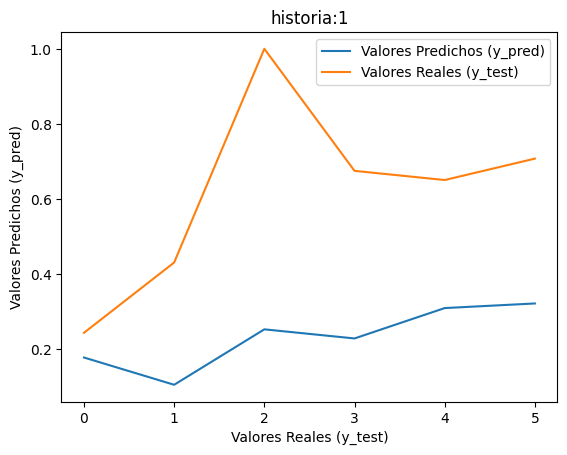

     y_test    y_pred
0  0.243910  0.209900
1  0.431052  0.243961
2  1.000000  0.098205
3  0.675044  0.490572
4  0.650645  0.243961
5  0.707576  0.440473


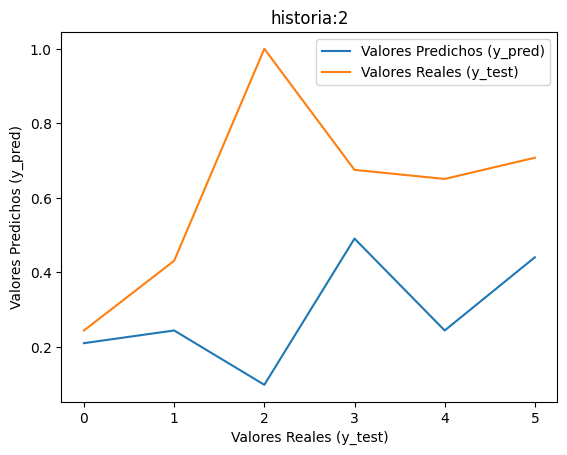

     y_test    y_pred
0  0.243910  0.190494
1  0.431052  0.161765
2  1.000000  0.168632
3  0.675044  0.260014
4  0.650645  0.269061
5  0.707576  0.271442


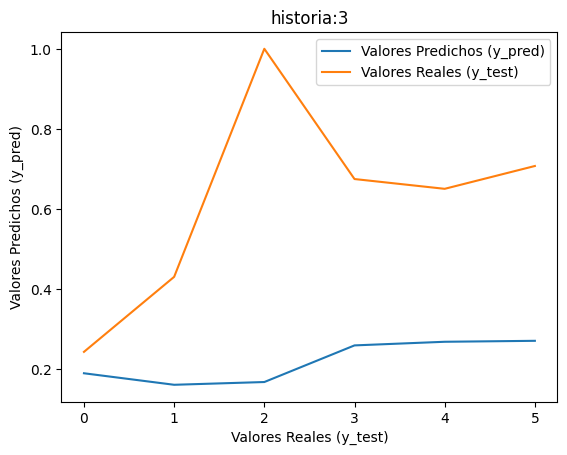

     y_test    y_pred
0  0.243910  0.166155
1  0.431052  0.179743
2  1.000000  0.183496
3  0.675044  0.275406
4  0.650645  0.299717
5  0.707576  0.385834


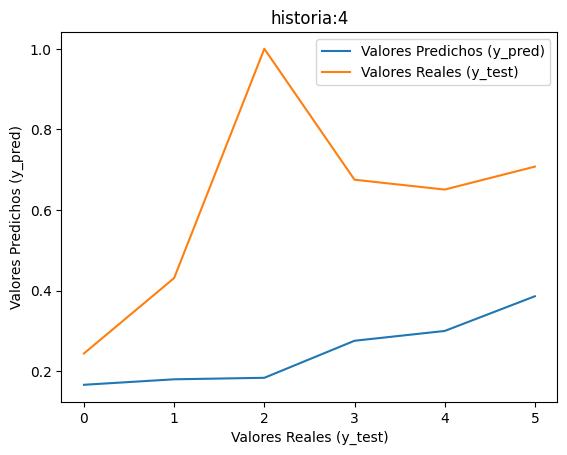

     y_test    y_pred
0  0.243910  0.197647
1  0.431052  0.134597
2  1.000000  0.161910
3  0.675044  0.343898
4  0.650645  0.340762
5  0.707576  0.216378


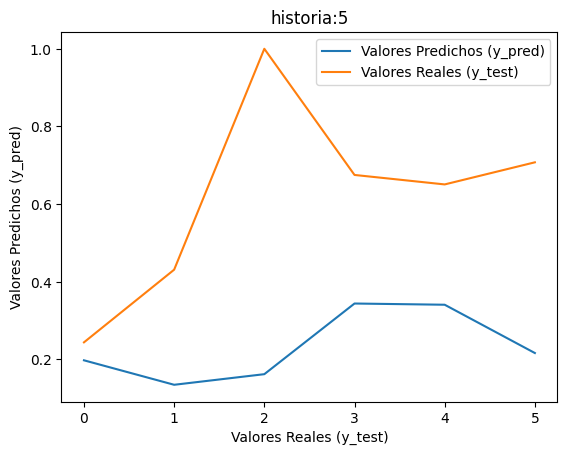

     y_test    y_pred
0  0.243910  0.180684
1  0.431052  0.174831
2  1.000000  0.144456
3  0.675044  0.335340
4  0.650645  0.375662
5  0.707576  0.344402


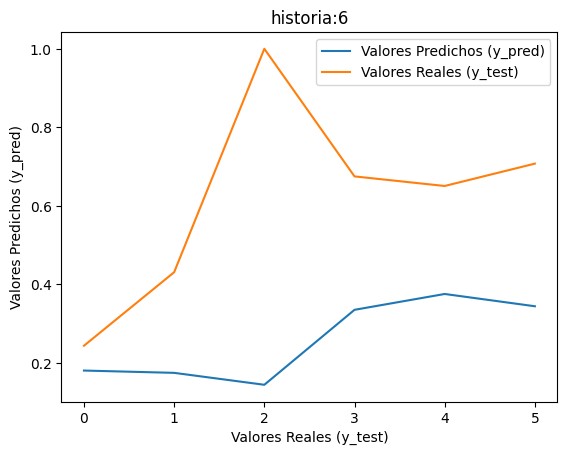

     y_test    y_pred
0  0.243910  0.181552
1  0.431052  0.179839
2  1.000000  0.244200
3  0.675044  0.365474
4  0.650645  0.355783
5  0.707576  0.406447


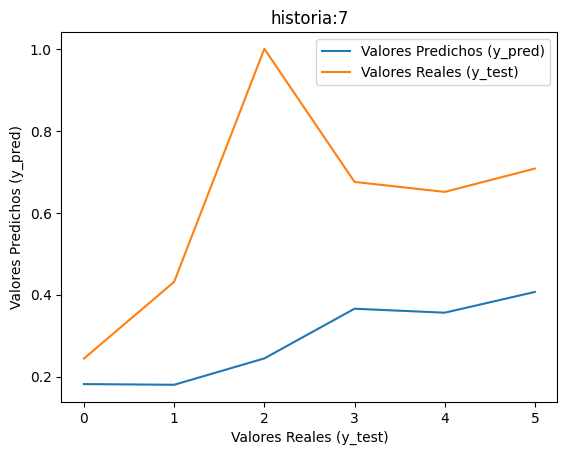

     y_test    y_pred
0  0.243910  0.214625
1  0.431052  0.227197
2  1.000000  0.272183
3  0.675044  0.441091
4  0.650645  0.270871
5  0.707576  0.434279


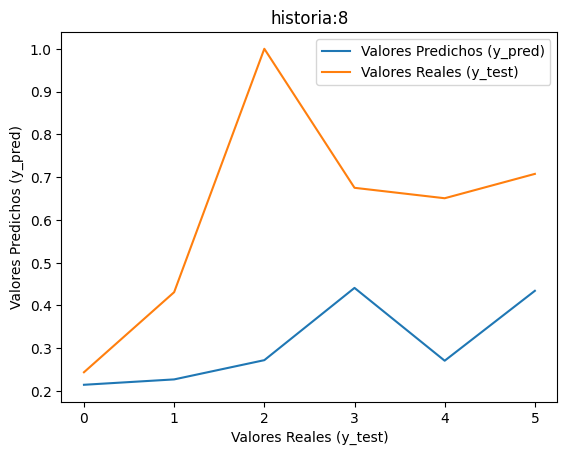

     y_test    y_pred
0  0.243910  0.209016
1  0.431052  0.244879
2  1.000000  0.262237
3  0.675044  0.435915
4  0.650645  0.385089
5  0.707576  0.315179


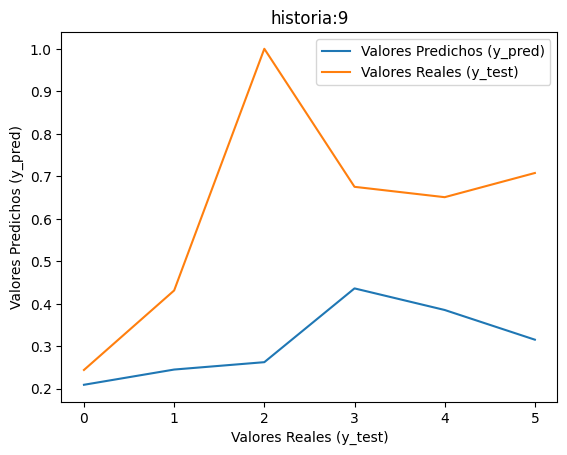

     y_test    y_pred
0  0.243910  0.218423
1  0.431052  0.230842
2  1.000000  0.255953
3  0.675044  0.409744
4  0.650645  0.370608
5  0.707576  0.303095


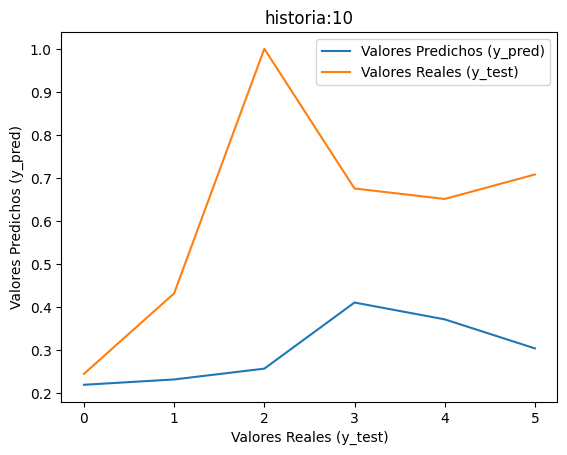

     y_test    y_pred
0  0.243910  0.219028
1  0.431052  0.231660
2  1.000000  0.254885
3  0.675044  0.401744
4  0.650645  0.387905
5  0.707576  0.333868


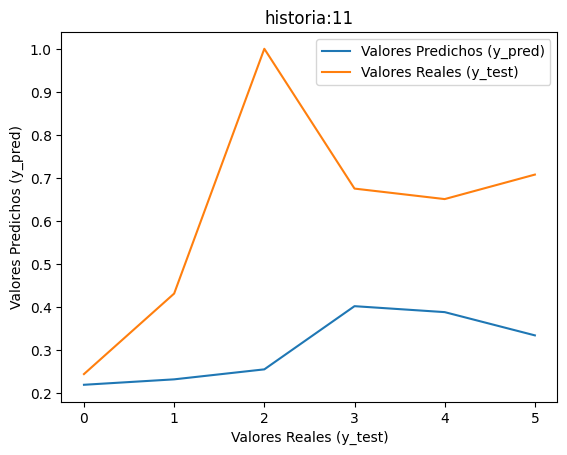

In [82]:

for i in range(len(df_resultado)):

    y_test = list(df_resultado.loc[i,['Y_TEST']].tolist()[0])
    y_pred = list(df_resultado.loc[i,['Y_PRED']].tolist()[0])

    data = {'y_test': y_test, 'y_pred': y_pred}
    df = pd.DataFrame(data)

    print(df)

    # Graficar las listas usando seaborn
    sns.lineplot(data=df['y_pred'], label='Valores Predichos (y_pred)')

    # Adicionar y_test como otra línea
    sns.lineplot(data=df['y_test'], label='Valores Reales (y_test)')

    plt.xlabel('Valores Reales (y_test)')
    plt.ylabel('Valores Predichos (y_pred)')
    plt.title('historia:' + str(i+1))
    plt.show()

     y_test    y_pred
0  0.243910  0.171891
1  0.431052  0.135710
2  1.000000  0.248929
3  0.675044  0.223844
4  0.650645  0.299532
5  0.707576  0.345030


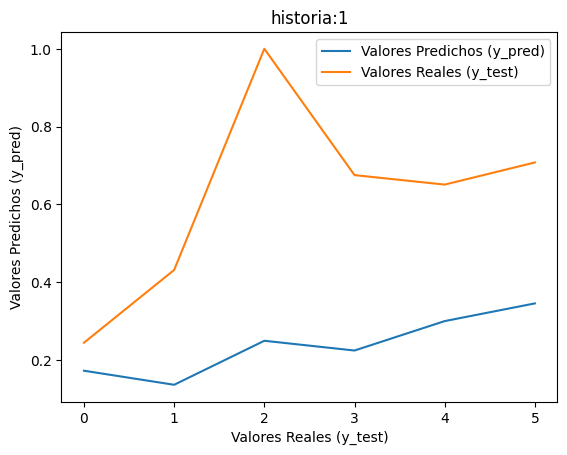

     y_test    y_pred
0  0.243910  0.175917
1  0.431052  0.119136
2  1.000000  0.200907
3  0.675044  0.297119
4  0.650645  0.331003
5  0.707576  0.300479


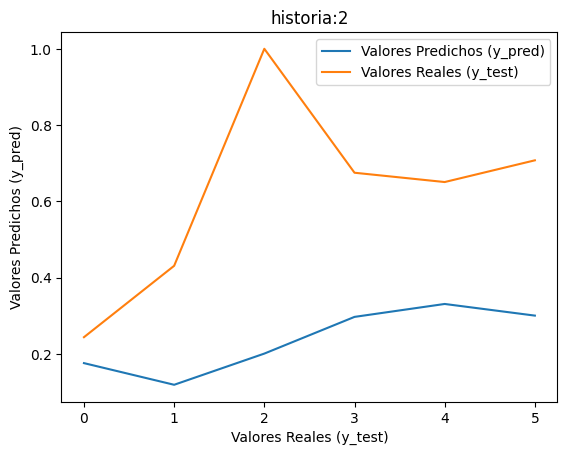

     y_test    y_pred
0  0.243910  0.172071
1  0.431052  0.171953
2  1.000000  0.180342
3  0.675044  0.264386
4  0.650645  0.271247
5  0.707576  0.284368


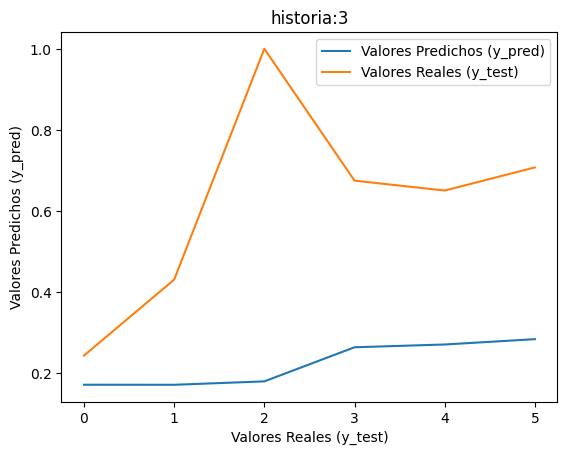

     y_test    y_pred
0  0.243910  0.162222
1  0.431052  0.173085
2  1.000000  0.177649
3  0.675044  0.281512
4  0.650645  0.331935
5  0.707576  0.371002


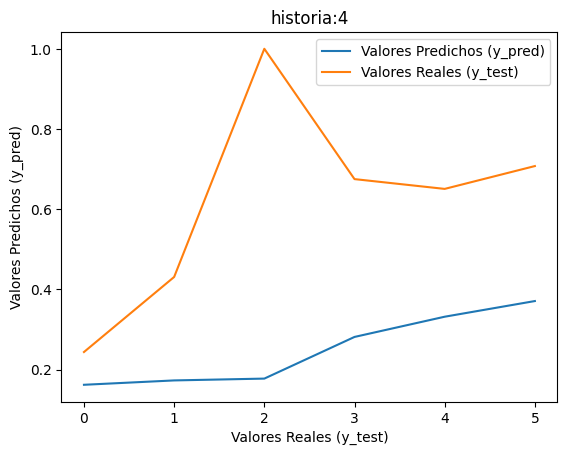

     y_test    y_pred
0  0.243910  0.146400
1  0.431052  0.166623
2  1.000000  0.189773
3  0.675044  0.359046
4  0.650645  0.390377
5  0.707576  0.231611


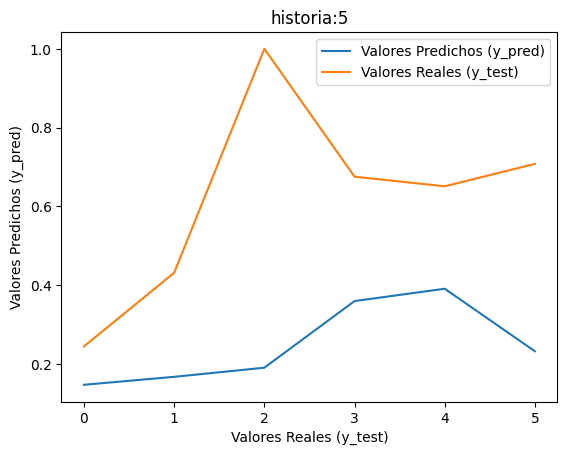

     y_test    y_pred
0  0.243910  0.197032
1  0.431052  0.190355
2  1.000000  0.148996
3  0.675044  0.350547
4  0.650645  0.410093
5  0.707576  0.356937


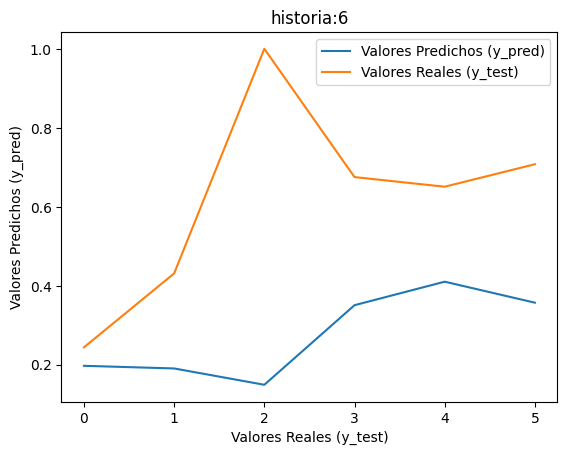

     y_test    y_pred
0  0.243910  0.172489
1  0.431052  0.174448
2  1.000000  0.193624
3  0.675044  0.362877
4  0.650645  0.371563
5  0.707576  0.383565


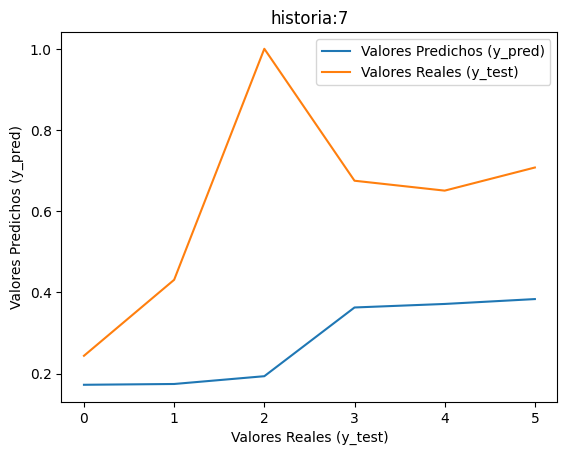

     y_test    y_pred
0  0.243910  0.223448
1  0.431052  0.233984
2  1.000000  0.245441
3  0.675044  0.475228
4  0.650645  0.322807
5  0.707576  0.459570


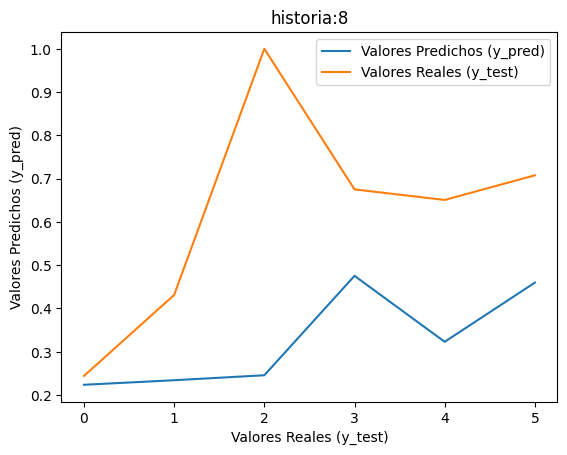

     y_test    y_pred
0  0.243910  0.204614
1  0.431052  0.242308
2  1.000000  0.240506
3  0.675044  0.431426
4  0.650645  0.377933
5  0.707576  0.274969


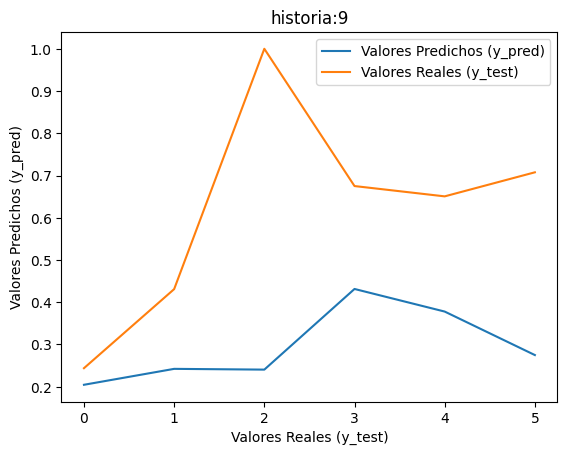

     y_test    y_pred
0  0.243910  0.226134
1  0.431052  0.250917
2  1.000000  0.270646
3  0.675044  0.449528
4  0.650645  0.387128
5  0.707576  0.330874


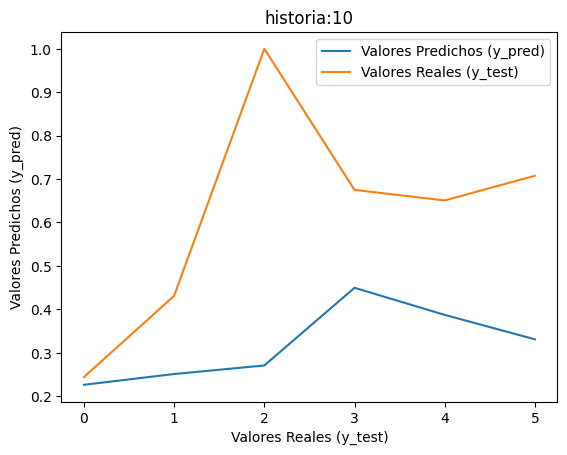

     y_test    y_pred
0  0.243910  0.204039
1  0.431052  0.242825
2  1.000000  0.251145
3  0.675044  0.396463
4  0.650645  0.350303
5  0.707576  0.319026


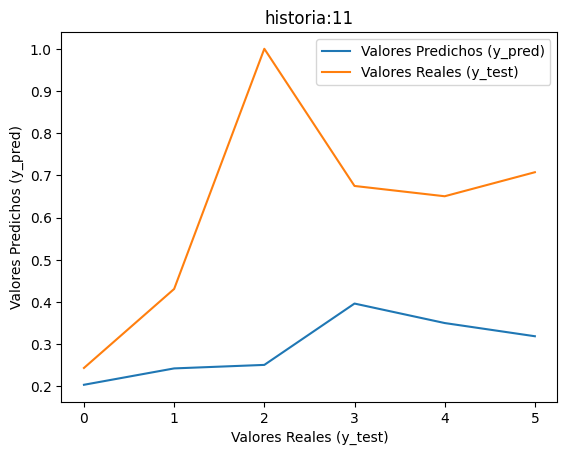